# Backtesting the strategy
To assess how effective our MA-cross strategy is, we will backtest it against historical data. By now we should already have all the data we need through gather_candles.ipynb and gather_mavg.ipynb. So here, we will test our strategy using the following conditions:
* Buy when the 5 MA crosses from below the 20 MA to above it but only if both the 5 MA and 20 MA are above the 50 MA.
* Sell when the 5 MA crosses from above the 20 MA to below it but only if both the 5 MA and 20 MA are below the 50 MA.

Inspiration for this strategy came from https://www.tradingview.com/chart/EURGBP/1ImcwzBC-The-Simplest-Scalping-Strategy-With-3-EMA-s-For-20-Pips-Per-Day/

In [9]:
import csv
import matplotlib.pyplot as plt
from utils import PBar
ochl_path = 'test_ochl.csv'
mavg_path = 'test_mavg.csv'

## Importing data

In [10]:
with open(ochl_path, 'r') as f:
    ochl = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))
with open(mavg_path, 'r') as f:
    mavg = list(csv.reader(f, quoting=csv.QUOTE_NONNUMERIC))
mavg5 = [a[1] for a in mavg]
mavg20 = [a[2] for a in mavg]
mavg50 = [a[3] for a in mavg]

## Strategy paramters
Risk and reward are important factors when implementing a strategy as they determine when we should take profit and when it is better to cut losses. Here we will set them both to 1%. For example, a long position will take a profit if there has been a 1% price increase and will take a loss whenever there has been a 1% price decrease.

In [11]:
risk = 0.01
reward = 0.01

## The backtest
Firstly we will define the MA-cross strategy within a function (for further use later on). Then using this strategy, we will iterate through the candlestick data, keeping track of profits and losses.

In [13]:
def MAcross(pbar):
    above50 = False
    above20 = False
    buy = False
    sell = False
    open_price = -1
    stop = -1
    target = -1
    PLs = []

    for i in range(50, len(ochl)):
        # Check if above or below the 50 MA
        if ochl[i][2] > mavg50[i] and mavg5[i] > mavg50[i] and mavg20[i] > mavg50[i]:
            above50 = True
        
        if mavg5[i] > mavg20[i]:
            if not above20:  # 5 MA cross from below to above the 20 MA
                buy = True
            else:
                buy = False
            above20 = True

        if mavg5[i] < mavg20[i]: # 5 MA cross from above to below the 20 MA
            if above20:
                sell = True
            else:
                sell = False
            above20 = False
        
        if open_price < 0: # If there is no current position
            if buy: # Open a long position
                open_price = ochl[i][2]
                stop = open_price * (1 - risk)
                target = open_price * (1 + reward)
                buy = False
            if sell: # Open a short position
                open_price = ochl[i][2]
                stop = open_price * (1 + risk)
                target = open_price * (1 - reward)
                sell = False
        else: # Otherwise check if the current position has been closed
            if ochl[i][4] <= target <= ochl[i][3]:
                PLs.append(reward)
                open_price = stop = target = -1
            if ochl[i][4] <= stop <= ochl[i][3]:
                PLs.append(-risk)
                open_price = stop = target = -1
        pbar.update()
    return PLs

pbar = PBar(len(ochl))
PLs = MAcross(pbar)
pbar.terminate()

100%|██████████| 100/100 [00:00&lt;00:00, 158.95it/s]


## Account balance over time
Starting with an account balance of 1 (equivalent to 100%), we will then iterate through the profits/losses and apply the changes to the account, keeping track of the balance at each step. This simulates the changes in the account balance over time when using the MA-cross strategy.

In [14]:
account = [1]
for change in PLs:
    bal = account[-1] * (1 + change)
    account.append(bal)

## Visualizing the results
To get a better understanding of how the strategy performed, we will plot an equity curve based off the account balance over time.

[&lt;matplotlib.lines.Line2D at 0x1153393d0&gt;]

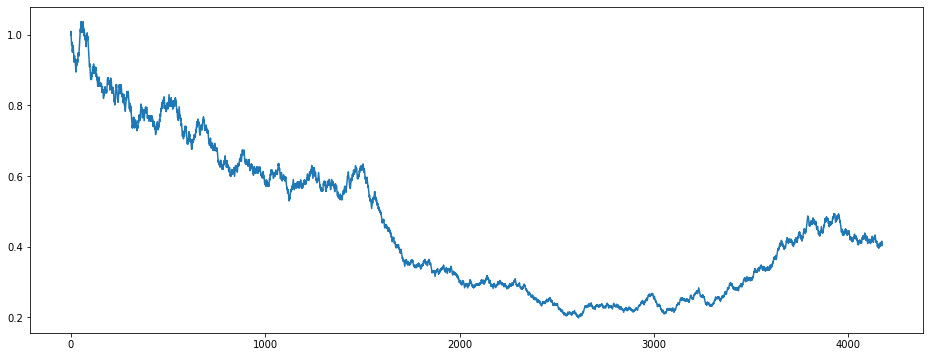

In [15]:
plt.figure(figsize=(16, 6))
x = list(range(len(account)))
plt.plot(x, account)